In [1]:
import lightning as L
import numpy as np

from txtox.data.datamodules import AnnDataGraphDataModule
from txtox.models.gnn import LitGNNv0
from txtox.utils import get_paths

n_genes = 500
n_labels = 126
paths = get_paths()
expname = "20241008_164102_VISp_nhood_GNN"
checkpoint_path = paths["data_root"] + f"checkpoints/{expname}"
datamodule = AnnDataGraphDataModule(data_dir=paths["data_root"], file_names=["VISp_nhood.h5ad"], batch_size=1)
model = LitGNNv0.load_from_checkpoint(
    checkpoint_path + "/epoch=154-val_rmse_overall=0.44.ckpt", input_size=n_genes, n_labels=n_labels
)

In [2]:
trainer = L.Trainer()
predictions = trainer.predict(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
xyz_pred = np.concatenate([p[0].reshape(1, -1) for p in predictions], axis=0)
celltype_pred = np.concatenate([p[1].reshape(1, -1) for p in predictions], axis=0)
print(xyz_pred.shape)
print(celltype_pred.shape)

(61884, 3)
(61884, 126)


In [4]:
from tqdm import tqdm

# del predictions

xyz = []
celltype = []

for batch in tqdm(datamodule.predict_dataloader()):
    _, _, xyz_batch, celltype_batch = batch
    xyz.append(xyz_batch.squeeze(0)[-1, :].numpy())
    celltype.append(celltype_batch.squeeze(0)[-1].numpy().reshape(-1))

100%|██████████| 61884/61884 [05:07<00:00, 201.33it/s]


In [5]:
xyz[0]

array([9.509721  , 0.90123725, 2.8952782 ], dtype=float32)

In [6]:
xyz_ = [entry.reshape(1, -1) for entry in xyz]
xyz_true = np.concatenate(xyz_, axis=0)
celltype_true = np.concatenate(celltype, axis=0)
xyz_full_pred = xyz_pred.copy()
celltype_full_pred = celltype_pred.copy()
print(xyz_true.shape)
print(celltype_true.shape)

(61884, 3)
(61884,)


In [7]:
x_err, y_err, z_err = (np.linalg.norm(xyz_true[:, [i]] - xyz_pred[:, [i]], axis=1).mean() for i in range(3))

print(f"x_ccf_full_err: {x_err:0.3f} mm")
print(f"y_ccf_full_err: {y_err:0.3f} mm")
print(f"z_ccf_full_err: {z_err:0.3f} mm")

x_ccf_full_err: 0.255 mm
y_ccf_full_err: 0.180 mm
z_ccf_full_err: 0.395 mm


In [8]:
x_err, y_err, z_err = (np.linalg.norm(xyz_true[:, [i]] - xyz_pred[:, [i]], axis=1).mean() for i in range(3))

print(f"x_ccf_err: {x_err:0.3f} mm")
print(f"y_ccf_err: {y_err:0.3f} mm")
print(f"z_ccf_err: {z_err:0.3f} mm")

x_ccf_err: 0.255 mm
y_ccf_err: 0.180 mm
z_ccf_err: 0.395 mm


In [9]:
xyz_true.shape

(61884, 3)

In [10]:
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

path = get_paths()["data_root"] + "VISp.h5ad"
adata = ad.read_h5ad(path)

In [11]:
adata.obs["x_pred"] = xyz_full_pred[:, 0]
adata.obs["y_pred"] = xyz_full_pred[:, 1]
adata.obs["z_pred"] = xyz_full_pred[:, 2]

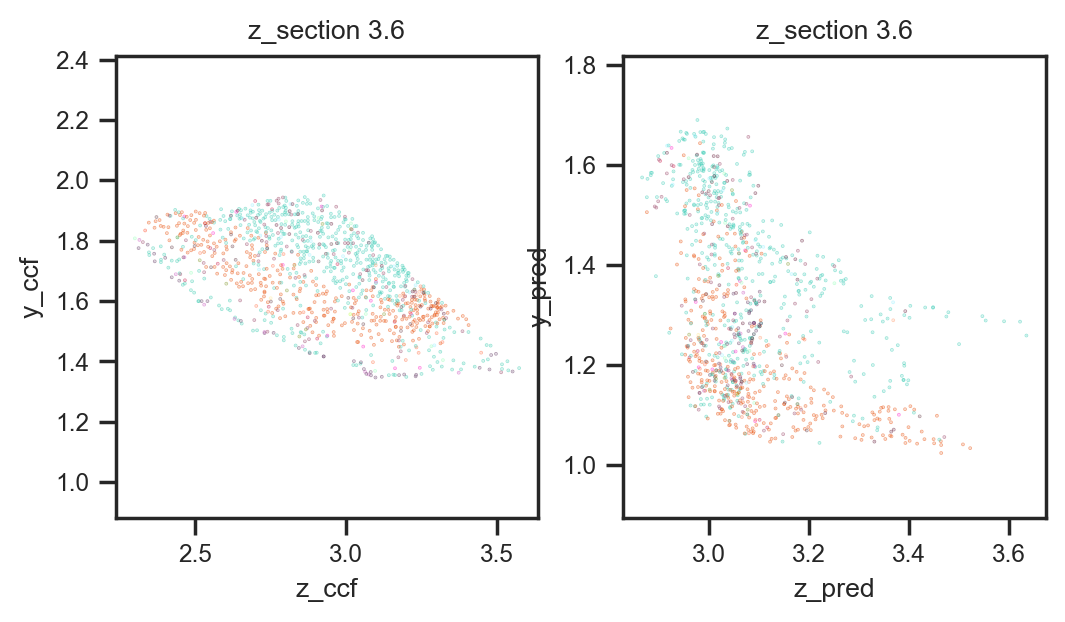

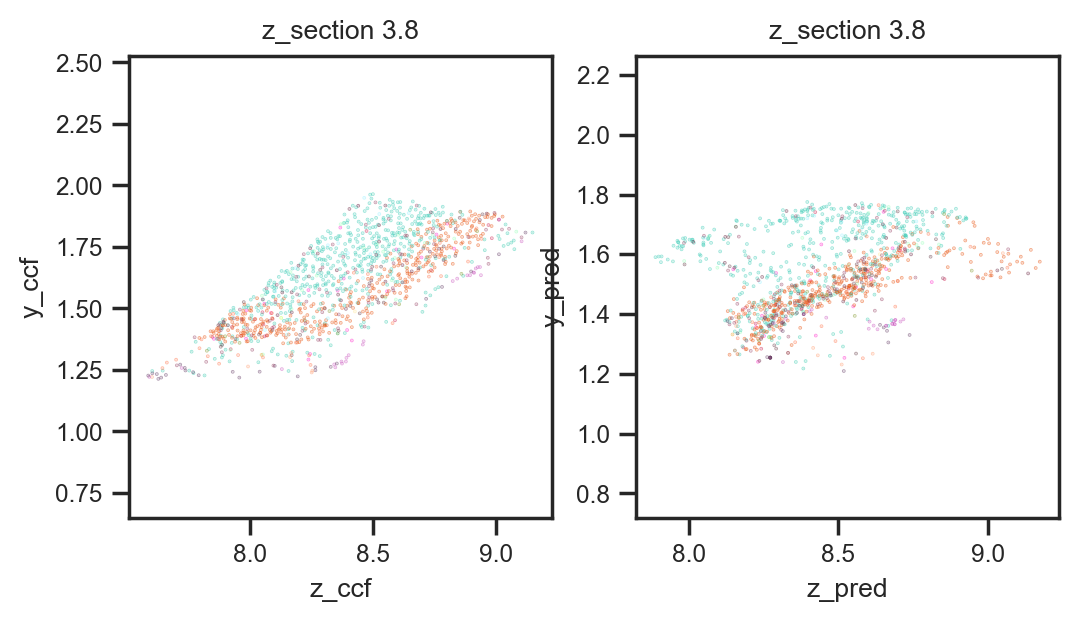

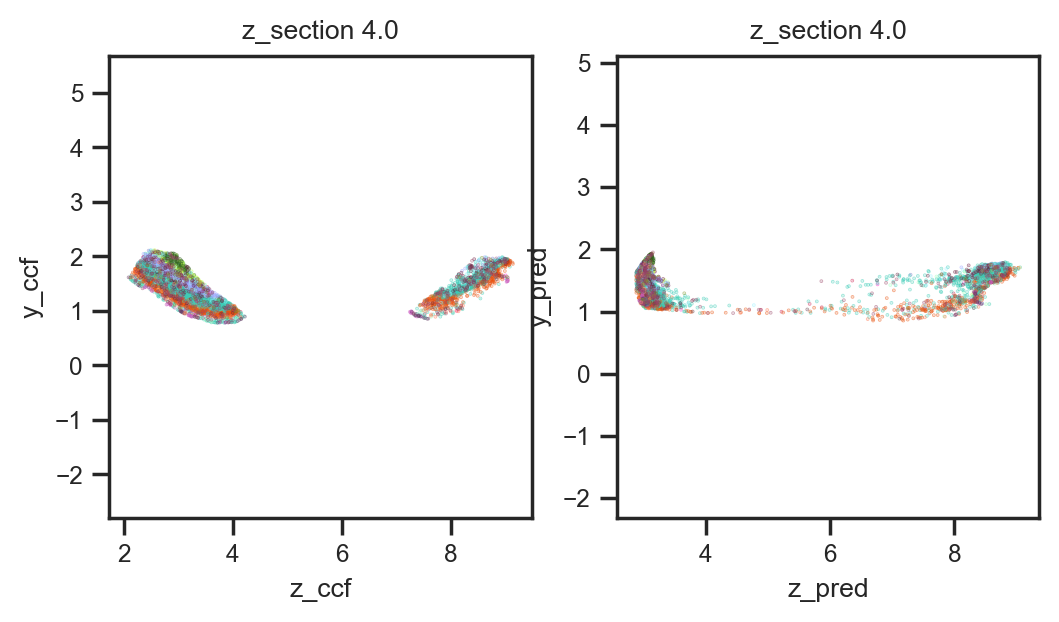

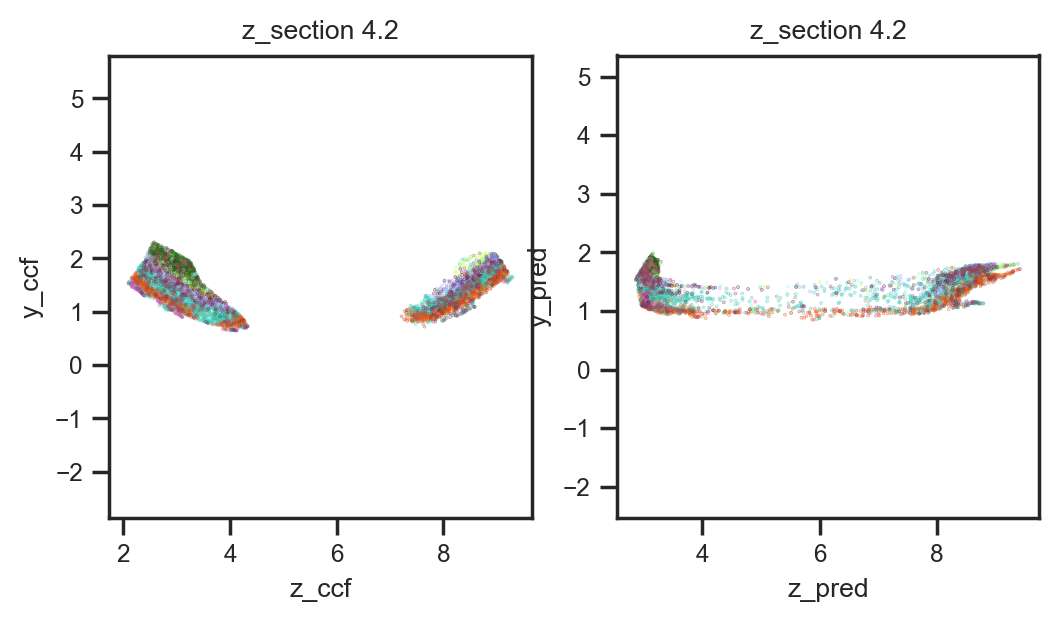

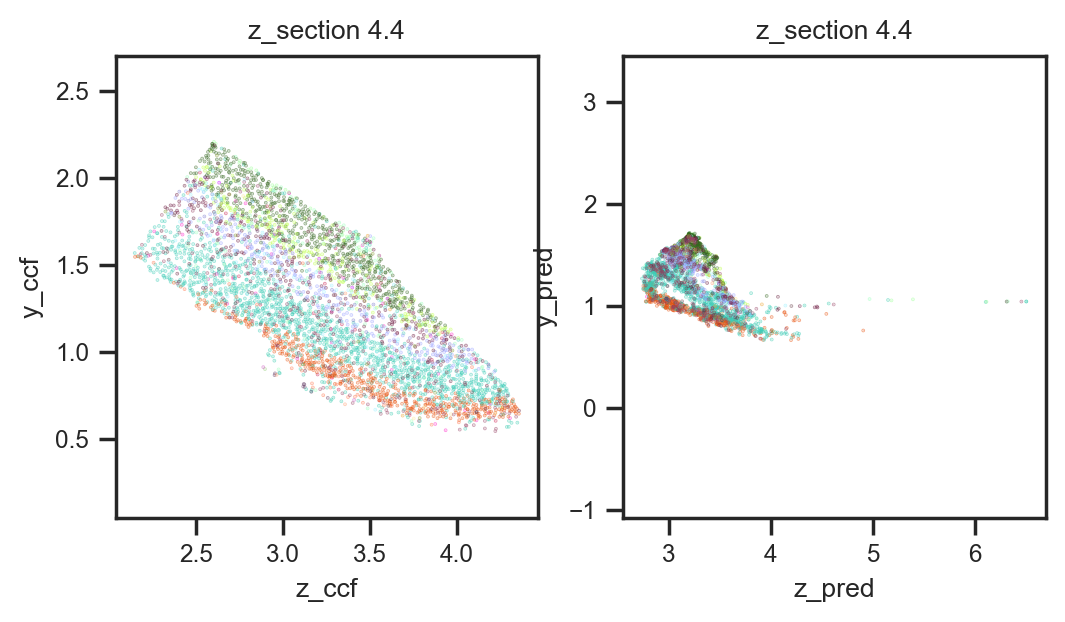

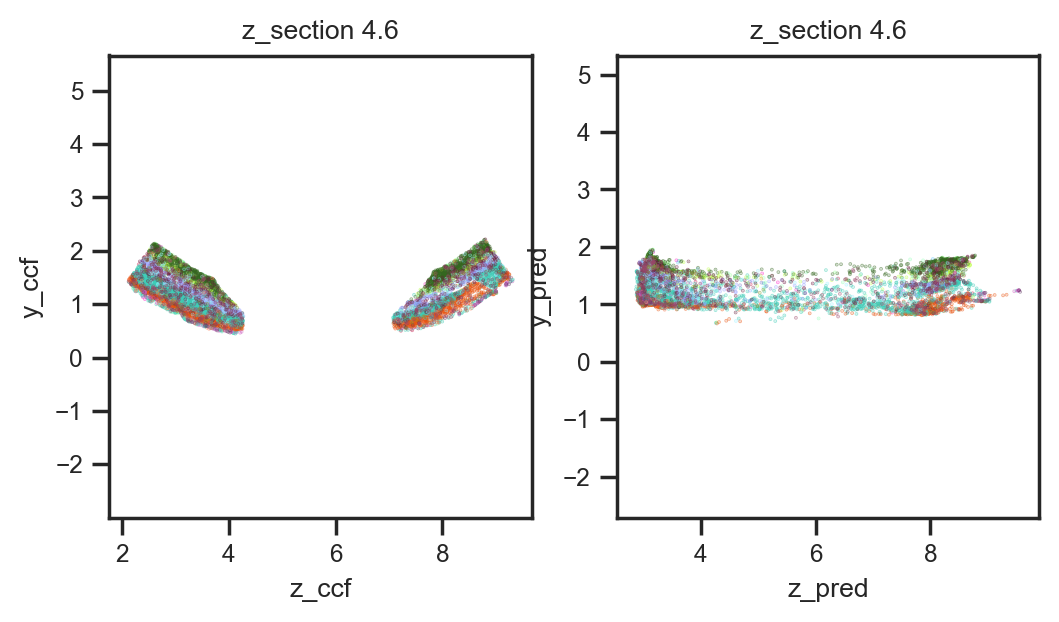

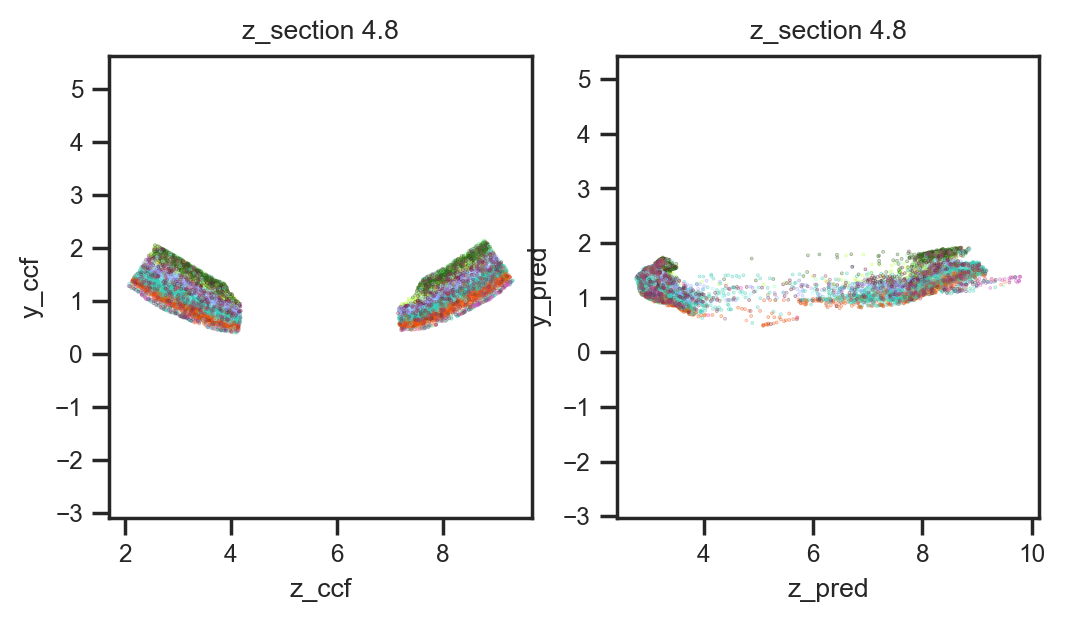

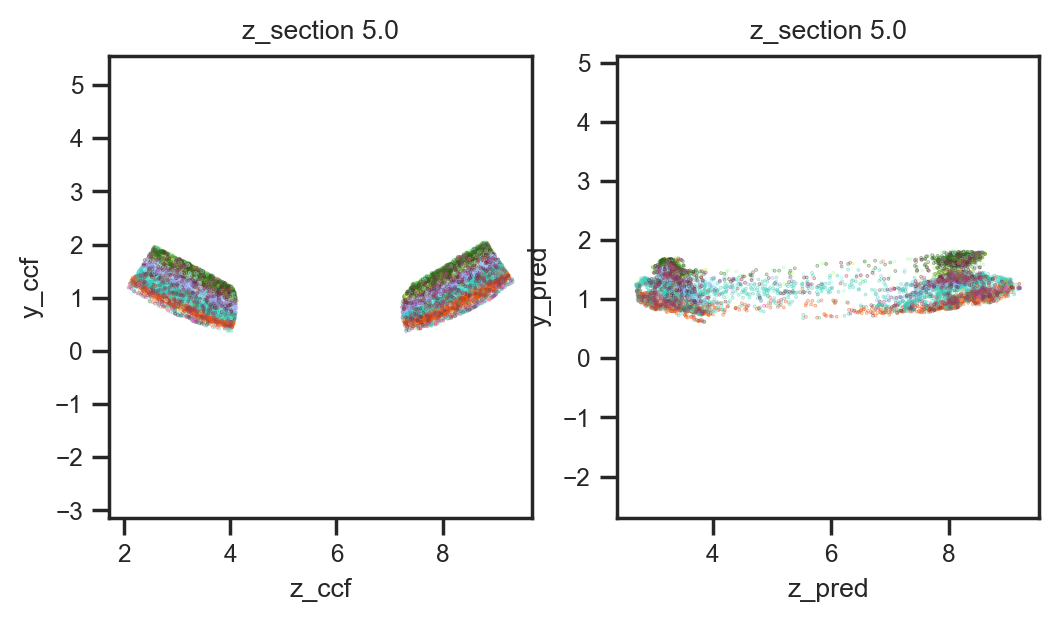

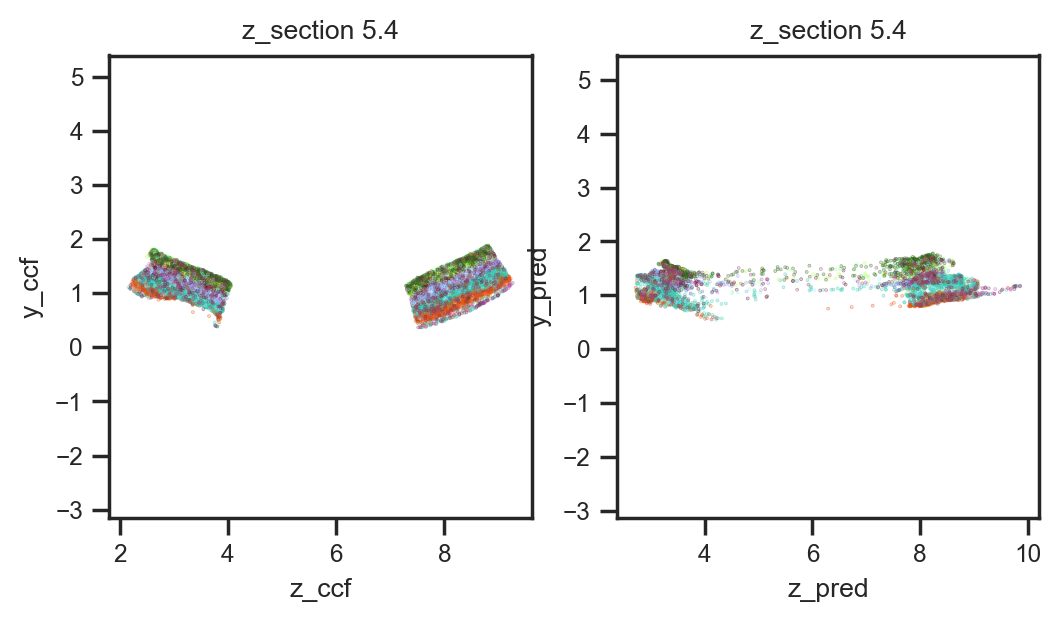

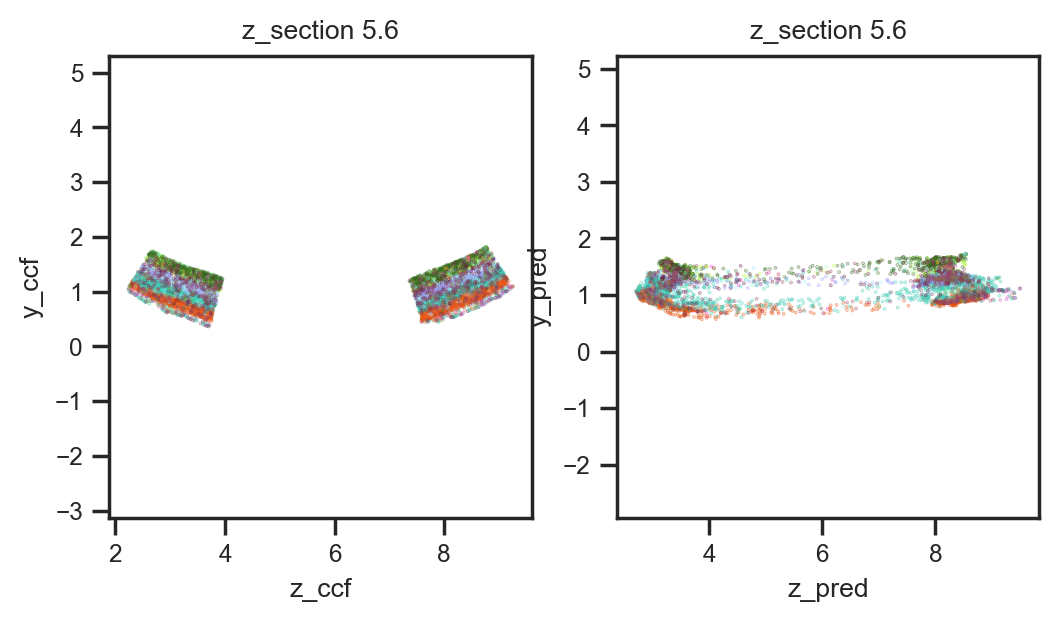

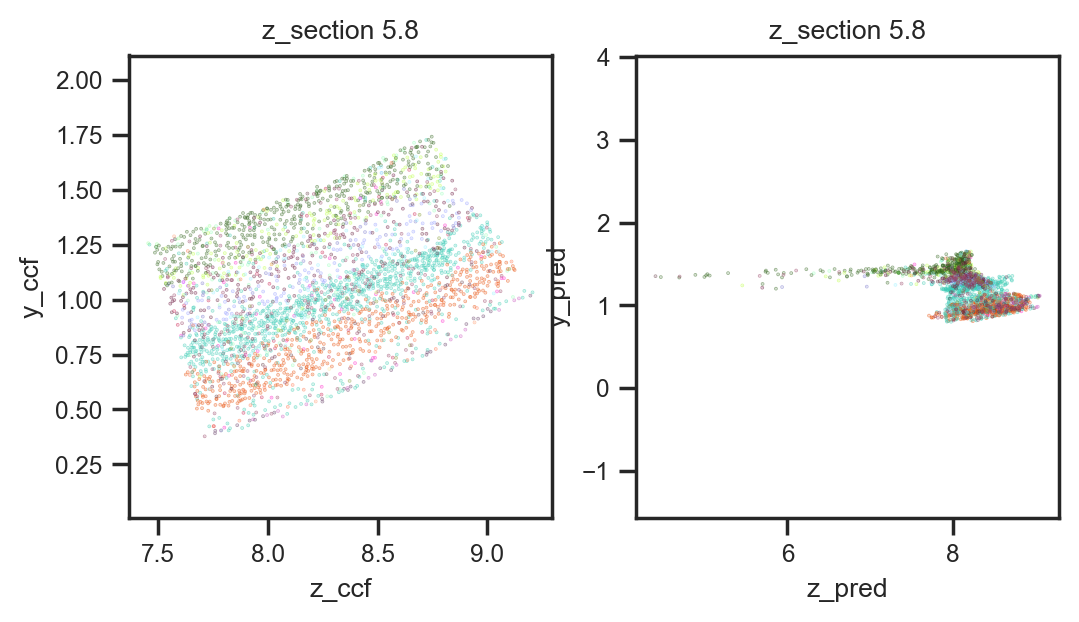

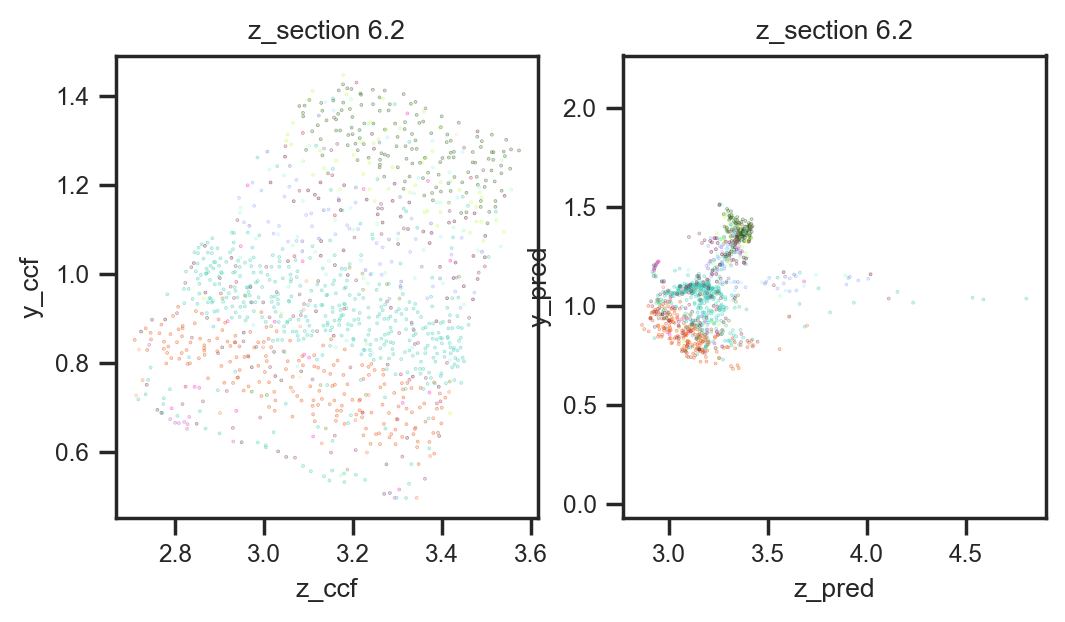

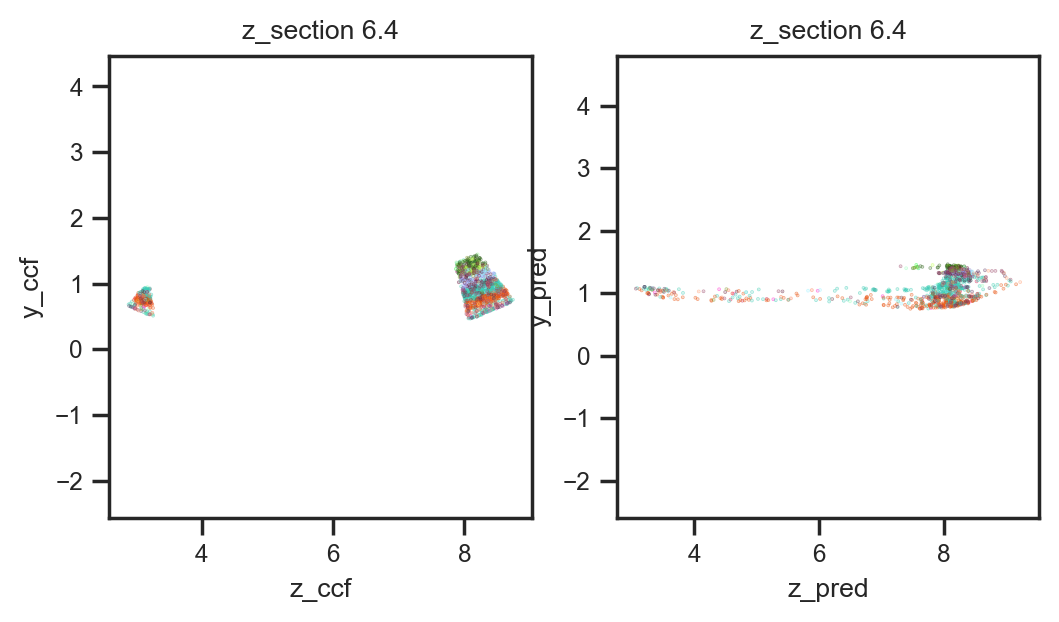

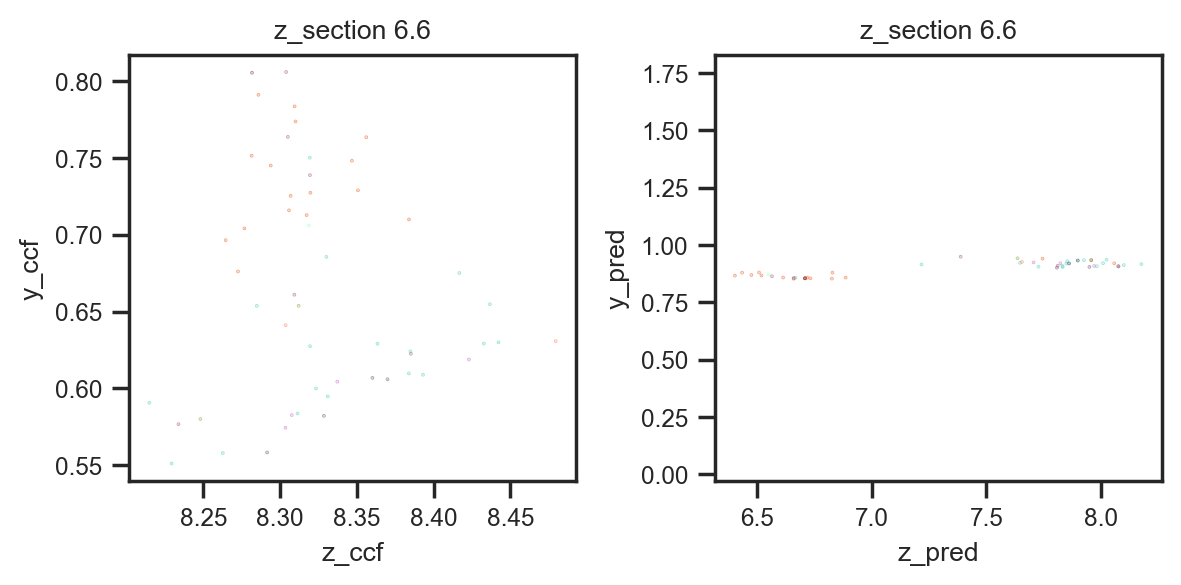

In [12]:
for section in np.sort(adata.obs["z_section"].unique()):
    ind = adata.obs["z_section"] == section

    # True values
    f, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].scatter(
        adata.obs["z_ccf"][ind],
        adata.obs["y_ccf"][ind],
        c=adata.obs["subclass_color"][ind],
        s=0.1,
        alpha=0.5,
        label=section,
    )
    ax[0].axis("equal")
    ax[0].set(xlabel="z_ccf", ylabel="y_ccf", title=f"z_section {section:0.1f}")

    # Predicted values
    ax[1].scatter(
        adata.obs["z_pred"][ind],
        adata.obs["y_pred"][ind],
        c=adata.obs["subclass_color"][ind],
        s=0.1,
        alpha=0.5,
        label=section,
    )
    ax[1].axis("equal")
    ax[1].set(xlabel="z_pred", ylabel="y_pred", title=f"z_section {section:0.1f}")

plt.tight_layout()
plt.show()